#  Lahman Baseball Data Analysis Using pyspark

## Introduction:
In this project, we will be using the Lahman Baseball Database (available at: http://www.seanlahman.com/baseball-archive/statistics/) to conduct various data analyses using different pyspark tools.    
Ref: http://www.seanlahman.com/files/database/readme2017.txt  
**The database is comprised of the following main tables:**  
  - People - Player names, DOB, and biographical info  
  - Batting - batting statistics  
  - Pitching - pitching statistics  
  - Fielding - fielding statistics<br>
  **It is supplemented by these tables:**  
  - AllStarFull - All-Star appearances  
  - HallofFame - Hall of Fame voting data  
  - Managers - managerial statistics  
  - Teams - yearly stats and standings   
  - BattingPost - post-season batting statistics  
  - PitchingPost - post-season pitching statistics  
  - TeamFranchises - franchise information  
  - FieldingOF - outfield position data    
  - FieldingPost- post-season fielding data  
  - FieldingOFsplit - LF/CF/RF splits  
  - ManagersHalf - split season data for managers  
  - TeamsHalf - split season data for teams  
  - Salaries - player salary data  
  - SeriesPost - post-season series information  
  - AwardsManagers - awards won by managers   
  - AwardsPlayers - awards won by players  
  - AwardsShareManagers - award voting for manager awards  
  - AwardsSharePlayers - award voting for player awards  
  - Appearances - details on the positions a player appeared at  
  - Schools - list of colleges that players attended  
  - CollegePlaying - list of players and the colleges they attended  
  - Parks - list of major league ballparls  
  - HomeGames - Number of homegames played by each team in each ballpark

We will start by importing the required pyspark tools.

In [0]:
import numpy as np
import pandas as pd
import pyspark.sql
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, rank, row_number
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()

## Section A - Load and Prepare Data
In this section, we will import the relevant DataFrames for analysis.

### A.1 - Load Data

Let's start by loading the required data.

In [0]:
# please chose the correct file location if you want to replicate the result
people = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/People.csv'))

batting = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/Batting.csv'))

teams = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/Teams.csv'))

franchises = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/TeamsFranchises.csv'))

parks = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/Parks.csv'))

homegames = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/HomeGames.csv'))

salaries = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/Salaries.csv'))

fielding = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/Fielding.csv'))

pitching = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/Pitching.csv'))

awards = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/AwardsPlayers.csv'))

appearances = (spark.read.option('delimiter', ',').option('header', True).option('inferSchema', True).csv('/FileStore/tables/lahman/Appearances.csv'))

### A.2 - The People Table
The following subsection takes a closer look at the people DataFrame.

Let's start by checking the column structure of the batting DataFrame.

In [0]:
print(people.columns)

['playerID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState', 'birthCity', 'deathYear', 'deathMonth', 'deathDay', 'deathCountry', 'deathState', 'deathCity', 'nameFirst', 'nameLast', 'nameGiven', 'weight', 'height', 'bats', 'throws', 'debut', 'finalGame', 'retroID', 'bbrefID']

Next, let's check the first 5 rows of 'playerID', 'nameFirst', 'nameLast', 'weight', and 'height' column of the DataFrame.

In [0]:
people.select('playerID', 'nameFirst', 'nameLast', 'weight', 'height').toPandas().head(5)

Out[4]:

,playerID,nameFirst,nameLast,weight,height
0,aardsda01,David,Aardsma,215.0,75.0
1,aaronha01,Hank,Aaron,180.0,72.0
2,aaronto01,Tommie,Aaron,190.0,75.0
3,aasedo01,Don,Aase,190.0,75.0
4,abadan01,Andy,Abad,184.0,73.0


Now, we will check the number of entries with missing values in the people DataFrame.

In [0]:
people.count() - people.dropna().count()

Out[5]: 11819

Let's review the DataFrame further by showing the columns with respective count of missing values in the people DataFrame.

In [0]:
people.select([expr(f'{people.count()} - COUNT({c}) AS {c}') for c in                               people.columns]).select(people.columns[:int(len(people.columns))]).toPandas() 

Out[6]:

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,0,114,282,423,61,534,174,10232,10233,10234,10237,10287,10243,37,0,37,816,736,1180,976,199,199,54,7


### A.3 - The Batting Table
The following subsection will take a closer look at the batting table.

Let's start by checking the column structure of the batting DataFrame.

In [0]:
print(batting.columns) 

['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']

Now, let's preview the first 5 rows of the batting DataFrame are shown below.

In [0]:
batting.toPandas().head(5) 

Out[8]:

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NA,1,4,0,0,0,0,0,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NA,25,118,30,32,6,0,0,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NA,29,137,28,40,4,5,0,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NA,27,133,28,44,10,2,2,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NA,25,120,29,39,11,3,0,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


Next, we will check the number of entries in the batting DataFrame with missing values.

In [0]:
(batting.count() - batting.dropna().count()) 

Out[9]: 36679

We can also check the missing values by each column.

In [0]:
batting.select([expr(f'{batting.count()} - COUNT({c}) AS {c}') for c in batting.columns]).toPandas()

Out[10]:

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,0,0,0,0,0,0,0,0,0,0,0,0,756,2368,23541,0,2100,36650,2816,6068,36103,25441


Now, Let's replace the missing values with zeros and display the first five rows. This will help us on future calculation.

In [0]:
batting = batting.fillna(0)
batting.toPandas().head(5)

Out[11]:

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NA,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,addybo01,1871,1,RC1,NA,25,118,30,32,6,0,0,13,8,1,4,0,0,0,0,0,0
2,allisar01,1871,1,CL1,NA,29,137,28,40,4,5,0,19,3,1,2,5,0,0,0,0,1
3,allisdo01,1871,1,WS3,NA,27,133,28,44,10,2,2,27,1,1,0,2,0,0,0,0,0
4,ansonca01,1871,1,RC1,NA,25,120,29,39,11,3,0,16,6,2,2,1,0,0,0,0,0


###A.4 - The Teams Table
The following subsection will take a closer examination of the teams table.

Let's start by checking the column structure of the batting DataFrame.

In [0]:
print(teams.columns)

['yearID', 'lgID', 'teamID', 'franchID', 'divID', 'Rank', 'G', 'Ghome', 'W', 'L', 'DivWin', 'WCWin', 'LgWin', 'WSWin', 'R', 'AB', 'H', '2B', '3B', 'HR', 'BB', 'SO', 'SB', 'CS', 'HBP', 'SF', 'RA', 'ER', 'ERA', 'CG', 'SHO', 'SV', 'IPouts', 'HA', 'HRA', 'BBA', 'SOA', 'E', 'DP', 'FP', 'name', 'park', 'attendance', 'BPF', 'PPF', 'teamIDBR', 'teamIDlahman45', 'teamIDretro']

Let's preview the first five rows of columns 'yearID', 'name', 'teamID', 'franchID', and 'lgID' of the teams DataFrame.

In [0]:
teams.select('yearID','name','teamID','franchID','lgID').toPandas().head(5)

Out[13]:

,yearID,name,teamID,franchID,lgID
0,1871,Boston Red Stockings,BS1,BNA,NA
1,1871,Chicago White Stockings,CH1,CNA,NA
2,1871,Cleveland Forest Citys,CL1,CFC,NA
3,1871,Fort Wayne Kekiongas,FW1,KEK,NA
4,1871,New York Mutuals,NY2,NNA,NA


Let's also calculate the number of entries with missing values within the teams DataFrame.

In [0]:
teams.count() - teams.dropna().count()

Out[14]: 2181

###A.5 - The Franchises Table
The following subsection will take a closer examination of the franchises table.

Let's start by checking the column structure of the batting DataFrame.

In [0]:
print(franchises.columns)

['franchID', 'franchName', 'active', 'NAassoc']

Now, let's preview the first five rows of the franchises DataFrame.

In [0]:
franchises.toPandas().head(5)

Out[16]:

,franchID,franchName,active,NAassoc
0,ALT,Altoona Mountain City,N,None
1,ANA,Los Angeles Angels of Anaheim,Y,None
2,ARI,Arizona Diamondbacks,Y,None
3,ATH,Philadelphia Athletics,N,PNA
4,ATL,Atlanta Braves,Y,BNA


Here, we will find the number of entries with missing values in the franchises DataFrame.

In [0]:
franchises.count() - franchises.dropna().count()

Out[17]: 108

We can also show the missing values by columns in the franchise DataFrame.

In [0]:
# display the number of rows in franchises
nrows = franchises.count() 

# count the number of missing values in each column in franchises
franchises.select([expr(f'{nrows} - COUNT({c}) AS {c}') for c in franchises.columns]).toPandas()


Out[18]:

,franchID,franchName,active,NAassoc
0,0,0,0,108


##Section B - Teams and Franchises
The following subsections will explore and calculate some statistics related to the history of the franchises.

### B.1 - Number of Franchises by Year

Let's display the trend in the number of franchises per year with line plot. As shown below, the number widely fluctuated in the beginning but has held steady since 1998.

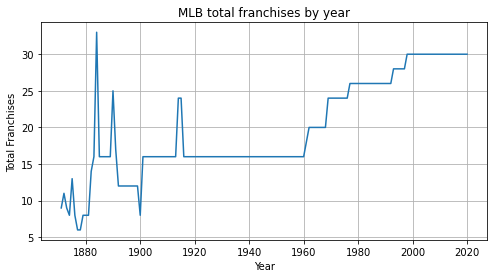

In [0]:
Franchises_by_Year = (
    teams
    .groupBy('yearID')
    .agg(
         expr('COUNT(DISTINCT(franchID)) AS total_franchises')
            )
    .sort('yearID', ascending = True)
    .toPandas()
)

plt.figure(figsize=[8,4])

plt.plot(Franchises_by_Year.yearID, Franchises_by_Year.total_franchises)
plt.xlabel('Year')
plt.ylabel('Total Franchises')
plt.title('MLB total franchises by year')
plt.grid()
plt.show()

###B.2 - Franchise Statistics
This subsection displays some statistics of the franchise dataframe. The teams and the franchises tables will be used.

Here, we are creating a DataFrame named franchise_summary with various summary statistics.

In [0]:
franchise_summary = (
 
teams
  .groupBy('franchID')
  .agg(
      expr('COUNT(DISTINCT(name)) AS num_names'),
      expr('MIN(yearID) AS first_year'),
      expr('MAX(yearID) AS last_year'),
      expr('COUNT(DISTINCT (yearID)) AS seasons'),
      expr('SUM(W) AS W'),
      expr('SUM(L) AS L') 
      )
  .select(
  '*', expr('ROUND(W / L,4) AS WL_ratio'))
  .join(franchises, 'franchID', 'left')
) 
print(franchise_summary.count())
franchise_summary.toPandas().head(10)

120
Out[20]:

,franchID,num_names,first_year,last_year,seasons,W,L,WL_ratio,franchName,active,NAassoc
0,PHA,1,1882,1890,9,560,498,1.1245,Philadelphia Athletics,N,None
1,NNA,1,1871,1875,5,151,122,1.2377,New York Mutuals,NA,NYU
2,NYM,1,1962,2020,59,4474,4842,0.9240,New York Mets,Y,None
3,SNA,1,1875,1875,1,39,29,1.3448,St. Louis Brown Stockings,NA,SBS
4,BRA,1,1872,1875,4,50,140,0.3571,Brooklyn Atlantics,NA,None
5,CHP,1,1890,1890,1,75,62,1.2097,Chicago Pirates,N,None
6,SLR,1,1875,1875,1,4,15,0.2667,St. Louis Red Stockings,NA,None
7,OAK,3,1901,2020,120,9064,9476,0.9565,Oakland Athletics,Y,None
8,BWW,1,1890,1890,1,76,56,1.3571,Brooklyn Ward's Wonders,N,None
9,PBB,1,1890,1890,1,60,68,0.8824,Pittsburgh Burghers,N,None


### B.3 - Franchises with the Most Names
This subsection will identify the franchise has existed under the most names.

First 10 rows are displayed after sorting in decreasing order of num_names.

In [0]:
franchise_summary.sort('num_names', ascending = False).toPandas().head(10)

Out[21]:

,franchID,num_names,first_year,last_year,seasons,W,L,WL_ratio,franchName,active,NAassoc
0,LAD,8,1884,2020,137,11017,9835,1.1202,Los Angeles Dodgers,Y,None
1,ATL,8,1876,2020,145,10732,10684,1.0045,Atlanta Braves,Y,BNA
2,CHC,4,1876,2020,145,11016,10430,1.0562,Chicago Cubs,Y,CNA
3,ANA,4,1961,2020,60,4735,4753,0.9962,Los Angeles Angels of Anaheim,Y,None
4,CLE,4,1901,2020,120,9512,9062,1.0497,Cleveland Indians,Y,None
5,STL,4,1882,2020,139,10948,10091,1.0849,St. Louis Cardinals,Y,None
6,OAK,3,1901,2020,120,9064,9476,0.9565,Oakland Athletics,Y,None
7,BAL,3,1901,2020,120,8793,9763,0.9006,Baltimore Orioles,Y,None
8,SFG,3,1883,2020,138,11194,9718,1.1519,San Francisco Giants,Y,None
9,CIN,3,1882,2020,139,10630,10422,1.0200,Cincinnati Reds,Y,None


Next, we will identify the teams with the greatest number of franchise names. Since there is a tie, ATL is chosen to be used for further analysis (it can be other way as well if desired). We will perform filtering, grouping and aggregation operations to determine the different ATL franchise names and then show the output.

In [0]:
#Identify the franchID value for the team with the greatest number of names. 
fID_names = (
    teams
    .groupBy('franchID')
    .agg(
        expr('COUNT(*) as n_franchID')
    
    )
    .sort('n_franchID', ascending=False)
    )

#Selected ATL as franchID with greatest number of names to analyze 
fID_names_yr = (
    teams
    .filter(expr('franchID == "ATL"'))
    .groupBy('franchID','name')
    .agg(
        expr('MIN(yearID) AS first_year'),
        expr('MAX(yearID) AS last_year')
    )
    .sort('first_year', ascending = False)
)
fID_names_yr.toPandas()


Out[22]:

,franchID,name,first_year,last_year
0,ATL,Atlanta Braves,1966,2020
1,ATL,Milwaukee Braves,1953,1965
2,ATL,Boston Bees,1936,1940
3,ATL,Boston Braves,1912,1952
4,ATL,Boston Rustlers,1911,1911
5,ATL,Boston Doves,1907,1910
6,ATL,Boston Beaneaters,1883,1906
7,ATL,Boston Red Caps,1876,1882


###B.4 - Age of Current Franchises
Using the 30 current franchises, the next subsection will discover how long each of them has existed.

Here, the age of the 30 current franchises is displayed in a horizontal bar graph. According to the chart, the two oldest franchises are the Atlanta Braves and the Chicago Cubs.

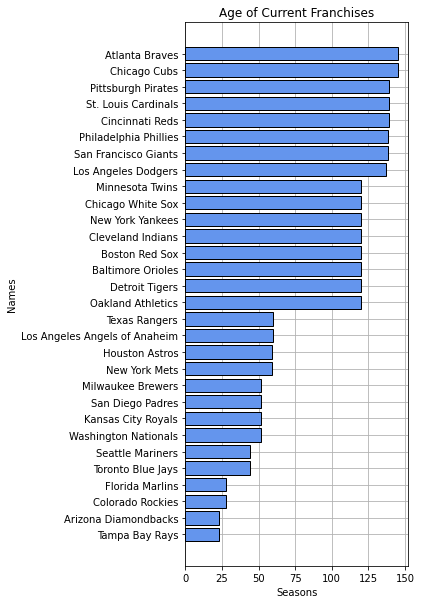

In [0]:
franchise_sum = franchise_summary.filter(col('active') == 'Y').sort('seasons', ascending = True).toPandas()

plt.figure(figsize=[4,10])

plt.barh(franchise_sum.franchName, franchise_sum.seasons, color='cornflowerblue', edgecolor='k', zorder = 2)
plt.title('Age of Current Franchises')
plt.xlabel('Seasons')
plt.ylabel('Names')
plt.grid()
plt.show()

###B.5 - Franchises with Best Win/Loss Ratios
Here, we will calculate the top 10 franchises according to their win/loss ratios.

Seen below, in the table, is the win/loss ratio for the first ten franchises.

In [0]:
(
    franchise_summary
        .sort('WL_ratio', ascending = False).select('franchID', 'franchName', 'seasons', 'first_year', 'last_year', 'WL_ratio')   
       ).toPandas().head(10)

Out[24]:

,franchID,franchName,seasons,first_year,last_year,WL_ratio
0,BNA,Boston Red Stockings,5,1871,1875,3.7500
1,MLU,Milwaukee Brewers,1,1884,1884,2.0000
2,BRS,Boston Reds,2,1890,1891,1.9333
3,PNA,Philadelphia Athletics,5,1871,1875,1.9186
4,COR,Cincinnati Outlaw Reds,1,1884,1884,1.9167
5,HAR,Hartford Dark Blues,2,1876,1877,1.6250
6,PRO,Providence Grays,8,1878,1885,1.5755
7,SBS,St. Louis Brown Stockings,2,1876,1877,1.4314
8,MLA,Milwaukee Brewers,1,1891,1891,1.4000
9,BWW,Brooklyn Ward's Wonders,1,1890,1890,1.3571


###B.6 - Win/Loss Ratios in Recent Years
Here, the win/loss ratio for each franchise will be calculated from the year 1998 and later.

In this subsection, filter, grouping and aggregation operations will be applied to the teams and franchises tables to calculate the win/loss ratio for each team currently active, convert it to a pandas DataFrame and display the result in horizontal bar chart.

The win/loss ratio of the 30 current franchises is displayed in a horizontal bar graph. According to the chart, New York Yankees has the highest win/loss ratio and Tampa Bay Devil Rays the lowest win/loss ratio.

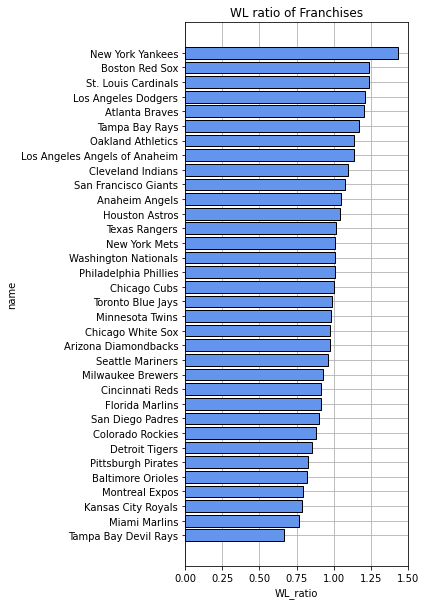

In [0]:
wl_ratio_df = (
teams
    .filter(expr('yearID >= 1998'))
    .join(franchises, 'franchID', 'inner')
    .filter(expr('active = "Y"'))
    .groupBy('name')
    .agg(
      expr('SUM(W) AS W'),
      expr('SUM(L) AS L') 
      )
    .select(
        '*', expr('ROUND(W / L, 4) AS WL_ratio'))
    .sort('WL_ratio').toPandas()
)

plt.figure(figsize=[4,10])
plt.barh(wl_ratio_df.name, wl_ratio_df.WL_ratio, color= 'cornflowerblue', edgecolor='k', zorder=2)
plt.title('WL ratio of Franchises')
plt.xlabel('WL_ratio')
plt.ylabel('name')
plt.grid()
plt.show()


##Section C - Batter Statistics
Various career statistics for each player will be explored in this section. Two in particular are batting average and slugging percentage.

###C.1 - Calculating Career Statistics
The career statistics for each batter will be calculated in this subsection.

Here, we will calculate the career statistics for each batter and store the result in a DataFrame named batters, and then print the number of records in batters and display the first 10 rows in this DataFrame.

In [0]:
batters = (
  batting
.groupBy('playerID')
.agg(
    expr('SUM(G) AS G'),
    expr('SUM(AB) AS AB'),
    expr('SUM(H) AS H'),
    expr('SUM(2B) AS 2B'),
    expr('SUM(3B) AS 3B'),
    expr('SUM(HR) AS HR'),
    expr('MIN(yearID) AS first_year'),
    expr('MAX(yearID) AS last_year'),
    expr('COUNT(DISTINCT (yearID)) AS seasons')
)
 .filter(expr('AB >= 1'))
 .select(
  '*', expr('ROUND(H / AB,4) AS BA'),
       expr('ROUND( (H + 2B + 2*3B + 3*HR) / AB,4) AS SP'))
  .join(people, 'playerID', 'left')
  .select('playerID','nameFirst','nameLast','first_year','last_year','seasons','height','weight','G','AB','H','2B','3B','HR','BA','SP')
)

print(batters.count())
batters.toPandas().head(10)

17593
Out[26]:

,playerID,nameFirst,nameLast,first_year,last_year,seasons,height,weight,G,AB,H,2B,3B,HR,BA,SP
0,gilliba01,Barney,Gilligan,1879,1888,10,66.0,130.0,521,1865,386,68,23,3,0.2070,0.2729
1,steenmi01,Milt,Steengrafe,1924,1926,2,72.0,170.0,16,15,0,0,0,0,0.0000,0.0000
2,lefloro01,Ron,LeFlore,1974,1982,9,72.0,200.0,1099,4458,1283,172,57,59,0.2878,0.3917
3,simpsdi01,Dick,Simpson,1962,1969,7,76.0,176.0,288,518,107,19,2,15,0.2066,0.3378
4,johnswa01,Walter,Johnson,1907,1927,21,73.0,200.0,933,2324,547,94,41,24,0.2354,0.3421
5,treshto01,Tom,Tresh,1961,1969,9,73.0,180.0,1192,4251,1041,179,34,153,0.2449,0.4110
6,hansesn01,Snipe,Hansen,1930,1935,5,75.0,195.0,156,200,31,3,0,0,0.1550,0.1700
7,stobbch01,Chuck,Stobbs,1947,1961,15,73.0,185.0,460,578,102,15,0,0,0.1765,0.2024
8,heganmi01,Mike,Hegan,1964,1977,12,73.0,188.0,965,2080,504,73,18,53,0.2423,0.3712
9,forscbo01,Bob,Forsch,1974,1989,16,76.0,200.0,509,893,190,45,8,12,0.2128,0.3214


### C.2 - Most Seasons Played
This subsection will show the most seasons played by the top 10 batters.

Here, we will sort the DataFrame in decreasing order by seasons and select specific columns to display the first 10 rows using the batters DataFrame.

In [0]:
(
  batters.sort('seasons', ascending = False)
         .select('nameFirst','nameLast','first_year', 'last_year', 'seasons')
        ).toPandas().head(10)


Out[27]:

,nameFirst,nameLast,first_year,last_year,seasons
0,Nolan,Ryan,1966,1993,27
1,Cap,Anson,1871,1897,27
2,Deacon,McGuire,1884,1912,26
3,Tommy,John,1963,1989,26
4,Charlie,Hough,1970,1994,25
5,Jamie,Moyer,1986,2012,25
6,Jim,Kaat,1959,1983,25
7,Eddie,Collins,1906,1930,25
8,Bobby,Wallace,1894,1918,25
9,Rickey,Henderson,1979,2003,25


###C.3 - Most At-Bats
The top 10 batters will be examined based on their number of times at-bat.

Columns 'nameFirst', 'nameLast', 'seasons', and 'AB' (at-bat) of the first 10 players with the greatest number of times at-bat is is displayed below.

In [0]:
batters.sort('AB', ascending = False).select('nameFirst', 'nameLast', 'seasons', 'AB').toPandas().head(10)

Out[28]:

,nameFirst,nameLast,seasons,AB
0,Pete,Rose,24,14053
1,Hank,Aaron,23,12364
2,Carl,Yastrzemski,23,11988
3,Cal,Ripken,21,11551
4,Ty,Cobb,24,11436
5,Eddie,Murray,21,11336
6,Derek,Jeter,20,11195
7,Adrian,Beltre,21,11068
8,Robin,Yount,20,11008
9,Dave,Winfield,22,11003


###C.4 - Highest Batting Average
The following subsection will identify the top 10 batters according to their batting averages and based on those batters with at least 100 at-bats.

Here, we will filter the batters DataFrame to keep only records for AB with 100 or more and display the first 10 rows.

In [0]:
(
    batters.filter('AB>=100')
           .sort('BA', ascending = False)
           .select('nameFirst', 'nameLast', 'AB', 'BA')
           .toPandas().head(10)
        )

Out[29]:

,nameFirst,nameLast,AB,BA
0,Ty,Cobb,11436,0.3663
1,Ross,Barnes,2391,0.3597
2,Rogers,Hornsby,8173,0.3585
3,Shoeless Joe,Jackson,4981,0.3558
4,Levi,Meyerle,1443,0.3555
5,Steve,King,272,0.3529
6,Lefty,O'Doul,3264,0.3493
7,George,Nicol,147,0.3469
8,Ed,Delahanty,7510,0.3458
9,Cal,McVey,2513,0.3458


###C.5 - Highest Slugging Percentage
The top 10 batters according to slugging percentage will be identified and will be based on those batters with at least 100 at-bats.

In [0]:
(
batters
    .filter(expr('AB >= 100'))
    .sort('SP', ascending = False)
    .select('nameFirst', 'nameLast', 'AB', 'SP').toPandas().head(10)
)

Out[30]:

,nameFirst,nameLast,AB,SP
0,Babe,Ruth,8398,0.6898
1,Yordan,Alvarez,321,0.6542
2,Edwin,Rios,123,0.6341
3,Ted,Williams,7706,0.6338
4,Lou,Gehrig,8001,0.6324
5,Jimmie,Foxx,8134,0.6093
6,Barry,Bonds,9847,0.6069
7,Hank,Greenberg,5193,0.6050
8,John,Bass,100,0.6000
9,Mark,McGwire,6187,0.5882


###C.6 - Relationship between Batting Average and Slugging Percentage
This subsection will examine the relationship between Batting Averages and Slugging Percentages visually based on batters with at least 100 at-bats.

First, we will filter the batters DataFrame to keep records for which AB >= 100. Then, we will take a portion of the filtered DataFrame and convert it to a Pandas DataFrame.   
The scatter plot of Batting Average against Slugging Percentage shows that there is a positive relationship between the two variables.

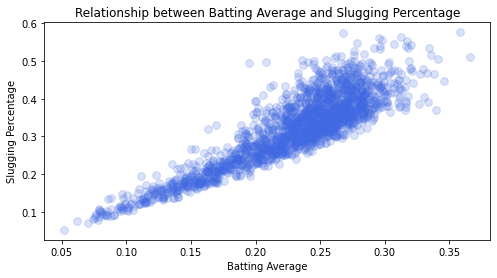

In [0]:
filter_batters = (
    batters
    .filter(expr('AB >= 100'))
    )

fbats_pdf = filter_batters.sample(withReplacement=False, fraction=0.2, seed=1).toPandas()
 
plt.figure(figsize=[8,4])
plt.scatter(fbats_pdf.BA, fbats_pdf.SP, alpha=0.2, c='royalblue', s=60)
plt.title('Relationship between Batting Average and Slugging Percentage')
plt.xlabel('Batting Average')
plt.ylabel('Slugging Percentage')
plt.show()

##Section D - Trends over Time
The following subsections will examine various statistics, or trends, over the time of the MLB.

### D.1 - Calculating Averages by Year
Here, we will evaluate a few features including average height and weight of each player by year, and overall batting averages and slugging percentages for all players by year.

First, create a Pandas DataFrame called by_year, using join, grouping and aggregation operations, calculate overall slugging percentage for all players, sorted in increasing order by yearID and shows the head of the by_year Pandas DataFrame.

In [0]:
by_year = (
    batting
    .join(people, 'playerID', 'left')
    .groupBy('yearID')
    .agg(
        expr('MEAN(weight) AS avg_wt'),
        expr('MEAN(height) AS avg_ht'),
        expr('SUM(AB) AS AB'),
        expr('SUM(H) AS H'),
        expr('SUM(2B) AS 2B'),
        expr('SUM(3B) AS 3B'),
        expr('SUM(HR) AS HR')
    )
    .select('*', 
            expr('ROUND(H / AB,4) AS BA'),
            expr('ROUND( (H + 2B + 2*3B + 3*HR) / AB,4) AS SP')
           )
    .sort('yearID', ascending = True)
   ).toPandas()
by_year.head()


Out[32]:

,yearID,avg_wt,avg_ht,AB,H,2B,3B,HR,BA,SP
0,1871,157.049505,68.509804,10822,3101,434,239,47,0.2865,0.3838
1,1872,159.847458,68.533333,15665,4467,581,145,37,0.2852,0.3478
2,1873,160.236559,68.612903,16959,4926,570,211,47,0.2905,0.3573
3,1874,161.075269,68.582418,19104,5224,634,194,40,0.2735,0.3332
4,1875,162.269461,68.725610,26833,6812,839,273,40,0.2539,0.3100


###D.2 - Trends for Height and Weight
This subsection visually displays the trends for height and weight over time.

According to the line plots, the height and weight of players has greatly increased compared to earlier years.

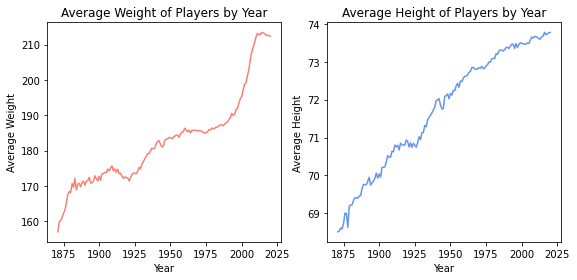

In [0]:
plt.figure(figsize = [8,4])

plt.subplot(1,2,1)
plt.plot(by_year.yearID, by_year.avg_wt, color = 'salmon')
plt.title('Average Weight of Players by Year')
plt.xlabel('Year')
plt.ylabel('Average Weight')

plt.subplot(1,2,2)
plt.plot(by_year.yearID, by_year.avg_ht, color = 'cornflowerblue')
plt.title('Average Height of Players by Year')
plt.xlabel('Year')
plt.ylabel('Average Height')

plt.tight_layout()
plt.show()

### D.3 - Trends for Batting Statistics
This subsection will visually explore the batting average and slugging percentage trends over time.

Here, we are displaying the line plots showing the trend in the batting average and slugging percentage over the years. The plots show that the general trend in batting average has not improved over the years but is less fluctuating relative to about 100 years ago. On the other hand, slugging percentage seems to be generally on an upward trend over the years.

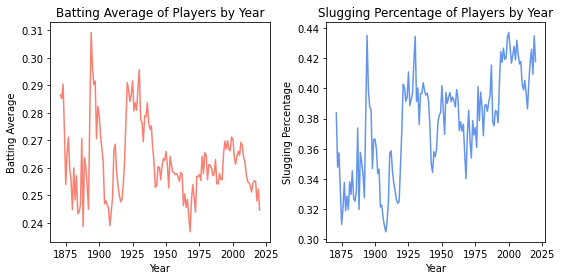

In [0]:
plt.figure(figsize = [8,4])

plt.subplot(1,2,1)
plt.plot(by_year.yearID, by_year.BA, color = 'salmon')
plt.title('Batting Average of Players by Year')
plt.xlabel('Year')
plt.ylabel('Batting Average')

plt.subplot(1,2,2)
plt.plot(by_year.yearID, by_year.SP, color = 'cornflowerblue')
plt.title('Slugging Percentage of Players by Year')
plt.xlabel('Year')
plt.ylabel('Slugging Percentage')

plt.tight_layout()
plt.show()

###D.4 - Trends for American and National Leagues
The next subsection will take the results from the previous two sections but examine them according to National or American league separately from 1960 onward.

Here, a DataFrame named by_year_and_league will be created with the calculations for average weight, average height, the totals for the columns of AB, H, 2B, 3B, and HR, plus the calculations for BA and SP. The first five rows of this new DataFrame is displayed below.

In [0]:
by_year_and_league = (
    batting
    .filter(expr('yearID >= 1960'))
    .join(people, 'playerID', 'left')
    .groupBy('yearID','lgID')
    .agg(
        expr('MEAN(weight) AS avg_wt'),
        expr('MEAN(height) AS avg_ht'),
        expr('SUM(AB) AS AB'),
        expr('SUM(H) AS H'),
        expr('SUM(2B) AS 2B'),
        expr('SUM(3B) AS 3B'),
        expr('SUM(HR) AS HR')
    )
    .select('*', 
            expr('ROUND(H / AB,4) AS BA'),
            expr('ROUND( (H + 2B + 2*3B + 3*HR) / AB,4) AS SP')
           )
    .sort('yearID', ascending = True)
).toPandas()
by_year_and_league.head()

Out[35]:

,yearID,lgID,avg_wt,avg_ht,AB,H,2B,3B,HR,BA,SP
0,1960,NL,186.210692,72.663522,42176,10745,1722,384,1042,0.2548,0.3879
1,1960,AL,186.476489,72.564263,41838,10689,1720,274,1086,0.2555,0.3876
2,1961,NL,185.820339,72.755932,42128,11029,1749,350,1196,0.2618,0.4051
3,1961,AL,185.774194,72.528536,54904,14037,2226,404,1534,0.2557,0.3947
4,1962,AL,185.378238,72.663212,55239,14068,2238,400,1552,0.2547,0.3940


Here, we will create the four line plots displaying the trends in average weight, average height, batting average, and slugging percentage for both the National and American Leagues. As shown below, the two leagues are fairly in range with each other.

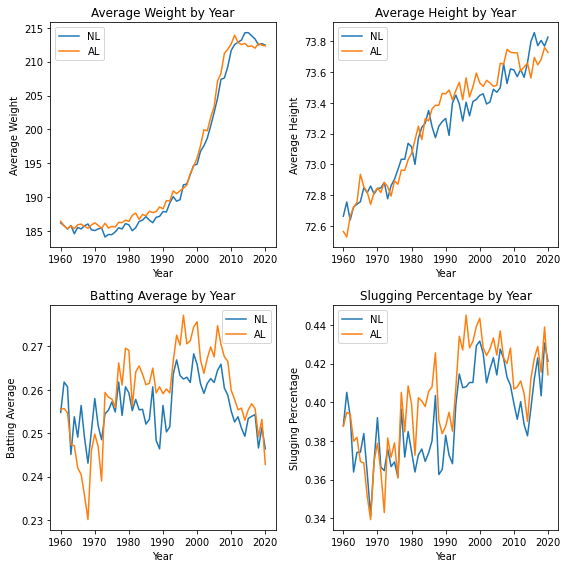

In [0]:
AL = by_year_and_league[by_year_and_league.lgID == 'AL']
NL = by_year_and_league[by_year_and_league.lgID == 'NL']


plt.figure(figsize = [8,8])

plt.subplot(2,2,1)
plt.plot(NL.yearID, NL.avg_wt, label = 'NL')
plt.plot(AL.yearID, AL.avg_wt, label = 'AL')
plt.title('Average Weight by Year')
plt.xlabel('Year')
plt.ylabel('Average Weight')
plt.legend()

plt.subplot(2,2,2)
plt.plot(NL.yearID, NL.avg_ht, label = 'NL')
plt.plot(AL.yearID, AL.avg_ht, label = 'AL')
plt.title('Average Height by Year')
plt.xlabel('Year')
plt.ylabel('Average Height')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(NL.yearID, NL.BA, label = 'NL')
plt.plot(AL.yearID, AL.BA, label = 'AL')
plt.title('Batting Average by Year')
plt.xlabel('Year')
plt.ylabel('Batting Average')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(NL.yearID, NL.SP, label = 'NL')
plt.plot(AL.yearID, AL.SP, label = 'AL')
plt.title('Slugging Percentage by Year')
plt.xlabel('Year')
plt.ylabel('Slugging Percentage')
plt.legend()

plt.tight_layout()
plt.show()

###D.5 - Average Number of Games
This subsection will show the average number of games played by each team during the MLB season.

The table shown below lists the first five rows depicting the number of franchises in each year and the average number of games played for that year.

In [0]:
games_per_season = (
    teams
        .groupBy('yearID')
        .agg(expr('SUM (G) as G'), expr('COUNT (DISTINCT franchID) AS num_franch'))
        .withColumn('avg_games', expr('ROUND(G/num_franch, 1)'))
        .sort('yearID', ascending = True)).toPandas()
games_per_season.head()

Out[37]:

,yearID,G,num_franch,avg_games
0,1871,254,9,28.2
1,1872,366,11,33.3
2,1873,398,9,44.2
3,1874,464,8,58.0
4,1875,690,13,53.1


Here, we will display the trends in the average number of games per season over time. As shown below, the number of games increased steadily until around the early 1900's and it appears that the numbers have been relatively flat since then. The downward spikes may be due to global events including the 2020 pandemic.

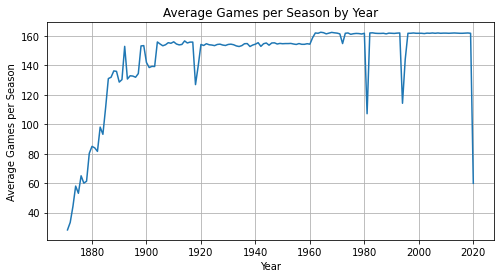

In [0]:
plt.figure(figsize = [8,4])

plt.plot(games_per_season.yearID, games_per_season.avg_games)
plt.title('Average Games per Season by Year')
plt.xlabel('Year')
plt.ylabel('Average Games per Season')

plt.grid()
plt.show()

## Section E - Exploration of salaries, teams, batting, fielding and pitching tables
In this section, we will explore various statistics related to salary and players performance.

###E.1 - Average salary of highest paid 15 players VS team's Win and Loss performance 
In this subsection, we will analyze the data to check if teams with players that received the highest average salaries will have more wins.

We will start by doing the basic salaries data overview - number of rows and missing values in each column of salaries DataFrame.

In [0]:
nrows = salaries.count()
print(nrows) 

salaries.select([expr(f'{nrows} - COUNT({c}) AS {c}') for c in salaries.columns]).toPandas()

26428
Out[39]:

,yearID,teamID,lgID,playerID,salary
0,0,0,0,0,0


Here, we will partition the DataFrame to select the highest 15 paid players from each team by year. This is to consider only top 15 players as the main players (rather than considering the whole team which may have several low earning players) of each team for comparison.

In [0]:
window = Window.partitionBy(salaries['yearID'], salaries['teamID']).orderBy(salaries['salary'].desc())

salary_top15 = salaries.select('*', rank().over(window).alias('rank')).filter(col('rank') <= 15)

salary_top15.toPandas().head()

Out[40]:

,yearID,teamID,lgID,playerID,salary,rank
0,1985,ATL,NL,murphda05,1625000,1
1,1985,ATL,NL,hornebo01,1500000,2
2,1985,ATL,NL,suttebr01,1354167,3
3,1985,ATL,NL,barkele01,870000,4
4,1985,ATL,NL,chambch01,800000,5


Here, we will aggregate the data to show average salary of 15 highest paid players by team and year.

In [0]:
salary_top15_agg = (
salary_top15.select('*')
    .groupby('teamID', 'yearID')
    .agg(
    expr('sum(salary) as sumsalary'),
    expr('COUNT(*) as Counts')
    )
    .select('*',
    expr('INT(sumsalary/Counts) AS Average_Salary_top15'))
    .sort('teamID','yearID')
)
salary_top15_agg.toPandas().head()

Out[41]:

,teamID,yearID,sumsalary,Counts,Average_Salary_top15
0,ANA,1997,27358972,15,1823931
1,ANA,1998,36890000,16,2305625
2,ANA,1999,46854166,15,3123611
3,ANA,2000,48029167,15,3201944
4,ANA,2001,43711667,15,2914111


Here, we will join the salary_top15_agg DataFrame with teams to link average salary to win_loss ratio.

In [0]:
avg_sal_vs_winloss = (
     salary_top15_agg
    .join(teams, ['teamID','yearID'],'inner' )
    .select('teamID', 'yearID', 'Average_Salary_top15',
    expr('ROUND(W/L, 4) AS Win_Loss_ratio'))
    .sort('yearID','Average_Salary_top15','Win_Loss_ratio', ascending = False)
)
 
avg_sal_vs_winloss.toPandas().head()

Out[42]:

,teamID,yearID,Average_Salary_top15,Win_Loss_ratio
0,NYA,2016,14072896,1.0769
1,LAN,2016,13141558,1.2817
2,DET,2016,12412232,1.1467
3,BOS,2016,12062834,1.3478
4,SFN,2016,11091851,1.1600


Here, we will visually display the average salary of team's highest paid 15 players vs win_loss ratio by year.  
The plots indicate that having a team with higher average salary players may not correlate to a higher win rate (higher win loss ratio).

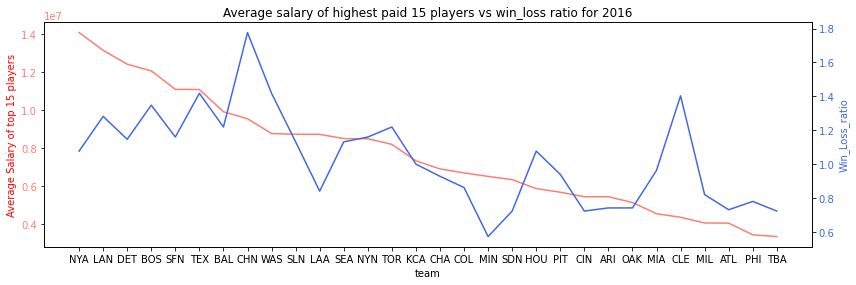

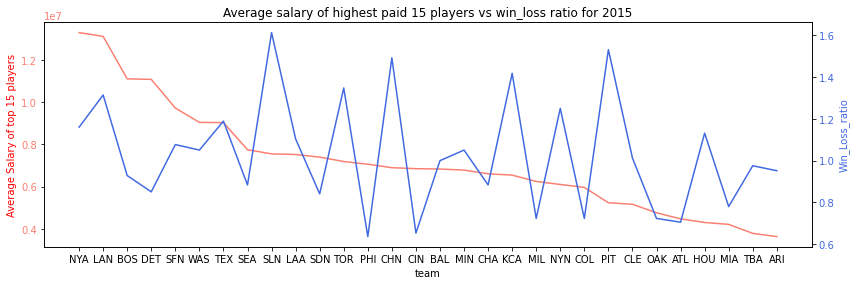

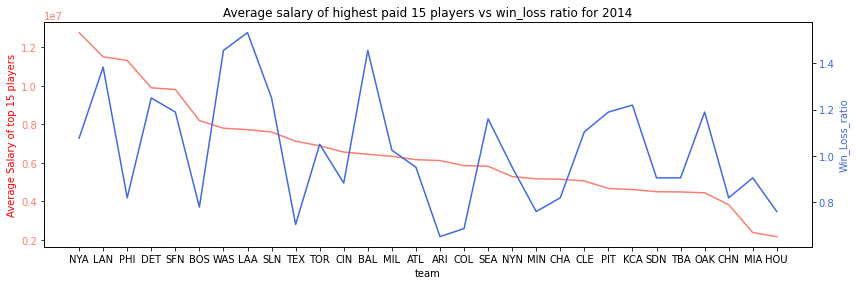

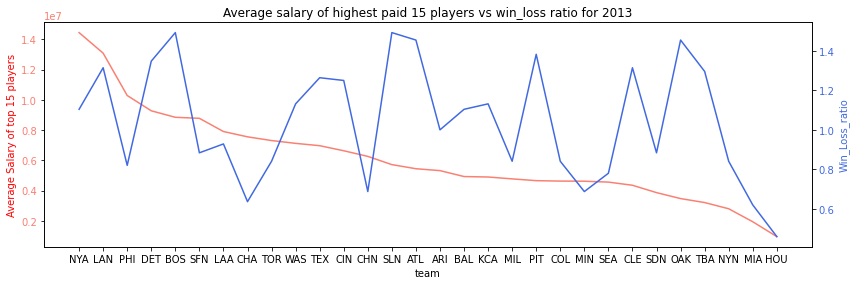

In [0]:
years = ['2016', '2015', '2014', '2013'] # select the year you want to compare
for i in range(len(years)):
    winloss_i = (
         avg_sal_vs_winloss
         .filter(expr(f'yearID == {years[i]}'))
         .select('*')).toPandas()
    
    fig, ax1 = plt.subplots(figsize=(12, 4))
    color = 'salmon'
    ax1.set_xlabel('team')
    ax1.set_ylabel('Average Salary of top 15 players', color='red')
    ax1.plot(winloss_i.teamID, winloss_i.Average_Salary_top15, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
 
    ax2 = ax1.twinx()
    color = 'royalblue'
    ax2.set_ylabel('Win_Loss_ratio', color=color)
    ax2.plot(winloss_i.teamID, winloss_i.Win_Loss_ratio, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.title(f'Average salary of highest paid 15 players vs win_loss ratio for {years[i]}')
    plt.show() 

###E.2 - Players Salary Increment VS Performance Change
In this subsection, we will check if salary increment of player will also generally lead to improvement in their performance.

Here, we will calculate the players (batters, fielders and pitcher) key performance indicators by year and join the tables into a single table to track the yearly key performance indicators (KPI) change.

In [0]:
# yearID = previous year
# yearID_plus1 = following year

# Calculate the batting performance indicators (BA and SP) for each players, each year
batters_PI = (batting.select('playerID','yearID', 'teamID', expr('ROUND(H / AB, 4) AS BA'),
                               expr('ROUND( (H + 2B + 2*3B + 3*HR) / AB, 4) AS SP')))
 
# Calculate fielding performance indicator as FE for each players, each year
# Reference for FE: https://sabr.org/journal/article/two-measures-of-fielding-ability/

fielding_PI = (fielding.select('playerID','yearID', 'teamID', expr('ROUND(((PO + A)/G)*(1+(DP-E)/G), 2) AS FE')))
 
# Show pitching performance indicator ERA and BAOpp for each players, each year
pitching_PI = (pitching.select('playerID', 'yearID', 'teamID','ERA', 'BAOpp'))
 
# Join batting, fielding and pitching data displaying the respective performance indicator of each player earch year
players_PI = (
    batters_PI.join(fielding_PI, ['playerID', 'yearID', 'teamID'], 'outer').join(pitching_PI, ['playerID', 'yearID', 'teamID'], 'outer'). select('*', expr('(yearID+1) AS yearID_plus1'))
)
 
# Prepare and rename the columns to be connected to the subsequent years (yearID_plus1) respective values for each players each year

players_PI_yearID_plus1 = (
    players_PI.select('playerID',expr('yearID AS yearID_plus1'), 'teamID', 
                      expr('BA AS BA_year_plus1'), expr('SP AS SP_year_plus1'), expr('FE AS FE_year_plus1'), expr('ERA AS ERA_year_plus1'), expr('BAOpp AS BAOpp_year_plus1'))
                     )

# Join the tables and find the year over year performance indicators differences (yearID_plus1 performance - yearID performance)
players_PI_YOY = players_PI.join(players_PI_yearID_plus1, ['yearID_plus1', 'playerID', 'teamID'], 'inner').select('yearID_plus1','playerID','yearID','teamID',expr('ROUND((BA_year_plus1 - BA), 4) AS BA_change'),expr('ROUND((SP_year_plus1 - SP), 4) AS SP_change'), expr('ROUND((FE_year_plus1 - FE),4) AS FE_change'), expr('ROUND((ERA_year_plus1 - ERA),4) AS ERA_change'), expr('ROUND((BAOpp_year_plus1 - BAOpp),4) AS BAOpp_change'))
 
players_PI_YOY.sort('yearID_plus1', 'playerID', ascending = False).toPandas().head(5)

Out[44]:

,yearID_plus1,playerID,yearID,teamID,BA_change,SP_change,FE_change,ERA_change,BAOpp_change
0,2020,zuninmi01,2019,TBA,-0.0187,0.0480,0.48,NaN,NaN
1,2020,zimmeky01,2019,KCA,NaN,NaN,0.33,-9.23,-0.162
2,2020,zimmejo02,2019,DET,NaN,NaN,-0.41,1.03,0.112
3,2020,zimmebr01,2019,CLE,0.1622,0.2432,-0.01,NaN,NaN
4,2020,zeuchtj01,2019,TOR,NaN,NaN,-0.60,-3.17,-0.041


Here, we will calculate the change in players' yearly salaries and filter the data to contain only players with 50% to 500% annual salary increment to exclude outlier.

In [0]:
salaries_year_0 = salaries.select('yearID', 'playerID', 'salary' ,expr('(yearID + 1) as yearID_plus1'))
 
salaries_yearID_plus1 = salaries.select( expr('yearID as yearID_plus1'),'playerID', expr('salary AS salary_year_plus1'))
 
salaries_YOY = salaries_year_0.join(salaries_yearID_plus1, ['yearID_plus1', 'playerID'], 'inner')
 
salaries_YOY_change = (
                     salaries_YOY
                            .select ('yearID_plus1', 'playerID', 
                             expr('ROUND((salary_year_plus1 - salary)*100/salary, 2) AS salary_change_pct'))
                              )
salaries_YOY_change = salaries_YOY_change.filter(expr('salary_change_pct >= 50 AND salary_change_pct <= 500')) 
 
# filter players to include only players with salary increment from 50% to 500% to eliminate low and extreme salary increment which could be due to multiple factors not related to players performance.
 
salaries_YOY_change.sort('salary_change_pct', ascending = False).toPandas().head(10)

Out[45]:

,yearID_plus1,playerID,salary_change_pct
0,1999,stairma01,500.00
1,2001,osunaan01,500.00
2,2001,castifr01,500.00
3,2003,ramirar01,500.00
4,2003,embreal01,500.00
5,2004,mechegi01,500.00
6,2007,burneaj01,500.00
7,2014,liriafr01,500.00
8,2005,izturce01,499.72
9,2015,jennide01,499.61


Here, we will compare players' annual salary increment (filtered by values between 50% to 500%) with their year over year performance change.

In [0]:
# yearID = previous year
# yearID_plus1 = following year

(salaries_YOY_change
     .join(players_PI_YOY, ['yearID_plus1', 'playerID'], 'inner')
     .select('yearID', 'yearID_plus1', 'playerID','salary_change_pct', 'BA_change', 'SP_change', 'FE_change','ERA_change', 'BAOpp_change')
     .sort('salary_change_pct', ascending = False)
    ).toPandas().head(10)

Out[46]:

,yearID,yearID_plus1,playerID,salary_change_pct,BA_change,SP_change,FE_change,ERA_change,BAOpp_change
0,2013,2014,liriafr01,500.00,0.0473,0.0473,-0.81,0.36,-0.006
1,2002,2003,ramirar01,500.00,0.0463,0.0610,-0.29,NaN,NaN
2,2006,2007,burneaj01,500.00,0.0000,0.0000,0.18,-0.23,-0.050
3,2003,2004,mechegi01,500.00,NaN,NaN,-0.63,0.42,0.010
4,1998,1999,stairma01,500.00,-0.0365,0.0225,-0.08,NaN,NaN
5,1998,1999,stairma01,500.00,-0.0365,0.0225,-15.67,NaN,NaN
6,1998,1999,stairma01,500.00,-0.0365,0.0225,-0.28,NaN,NaN
7,1998,1999,stairma01,500.00,-0.0365,0.0225,-15.87,NaN,NaN
8,2002,2003,embreal01,500.00,NaN,NaN,-0.01,1.28,0.038
9,2004,2005,izturce01,499.72,-0.0313,-0.0585,0.12,NaN,NaN


### E.3 - Salary Trend over the Years
In this subsection, we will first determine the total annual salary and the average annual salary for each player and view the salary trends over the years starting from 1985, and then we will calculate some of the salary statistics for each player the first year and the last year.

We will start by calculating the total annual salary and the average annual salary for each player each year and respectively create a line plot and a vertical bar chart to view the result.
The line plot (left) shows that the total annual salary for each player increased over the years. We observed that it dropped around 2014 and went up again in 2015. The vertical bar chart confirms that the average annual salary for each player also increases over time.

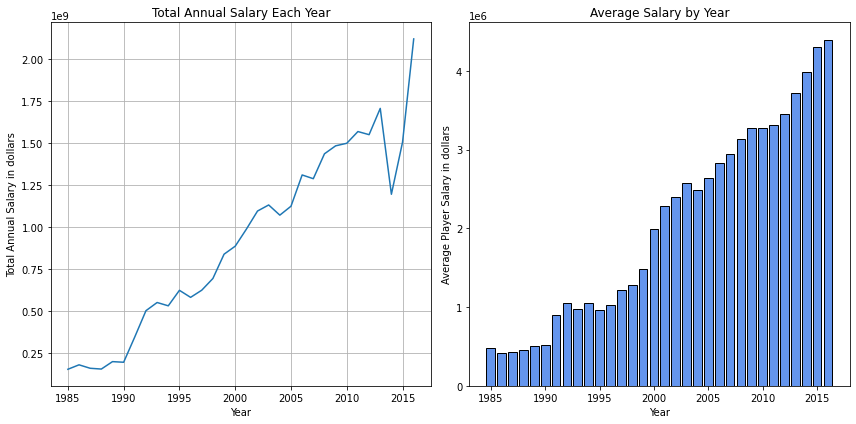

In [0]:
Salary_By_Year = (
    salaries
    .groupBy('yearID')
    .agg(
         expr('SUM(DISTINCT(salary)) AS total_salary'),
         expr('MEAN(salary) AS Average_salary')
            )
    .sort('yearID', ascending = True)
    .toPandas()
)

plt.figure(figsize=[12,6])

plt.subplot(1,2,1)
plt.plot(Salary_By_Year.yearID, Salary_By_Year.total_salary)
plt.xlabel('Year')
plt.ylabel('Total Annual Salary in dollars')
plt.title('Total Annual Salary Each Year')
plt.grid()

plt.subplot(1,2,2)
plt.bar(Salary_By_Year['yearID'], Salary_By_Year['Average_salary'], color='cornflowerblue', edgecolor='k',zorder = 2)
plt.title('Average Salary by Year')
plt.ylabel('Average Player Salary in dollars')
plt.xlabel('Year')

plt.tight_layout()
plt.show()



Here, we will calculate the maximum, minimum and average salary for each player for the first and last year and the resulting DataFrame will be sorted in decreasing order by Average_salary.

In [0]:
salary_by_player = (
  salaries
.groupBy('playerID')
.agg(
    expr('MAX(salary) AS Maximum_salary'),
    expr('MIN(salary) AS Minimum_salary'),
    expr('ROUND(MEAN(salary),2) AS Average_salary'),
    expr('MIN(yearID) AS first_year'),
    expr('MAX(yearID) AS last_year'),
    expr('COUNT(DISTINCT (yearID)) AS seasons')
)
  .join(people, 'playerID', 'left')
  .select('playerID','nameFirst','nameLast','first_year','last_year','seasons',
          'Maximum_salary','Minimum_salary','Average_salary').sort('Average_salary', ascending=False).toPandas()
)

salary_by_player.head(10)

Out[48]:

,playerID,nameFirst,nameLast,first_year,last_year,seasons,Maximum_salary,Minimum_salary,Average_salary
0,tanakma01,Masahiro,Tanaka,2014,2016,3,22000000,22000000,22000000.00
1,rodrial01,Alex,Rodriguez,1994,2016,22,33000000,442333,18109829.64
2,howarry01,Ryan,Howard,2006,2015,10,25000000,355000,15525500.00
3,teixema01,Mark,Teixeira,2003,2016,14,23125000,750000,15305357.14
4,sabatcc01,CC,Sabathia,2002,2016,15,25000000,700000,14576190.40
5,jeterde01,Derek,Jeter,1996,2014,19,22600000,130000,13927268.05
6,fieldpr01,Prince,Fielder,2006,2016,11,24000000,329500,13901318.18
7,cabremi01,Miguel,Cabrera,2003,2016,14,28000000,165574,13457901.64
8,mauerjo01,Joe,Mauer,2004,2016,13,23000000,300000,13232692.31
9,cespeyo01,Yoenis,Cespedes,2012,2016,5,27328046,8500000,13165609.20


###E.4 - Fielding Statistics
In this subsection, we will calculate the fielding percentage and stolen base percentage for each team and store the result in a DataFrame named fielding_stolen_percentage. We will keep only the records from 2000 and later.

First, let's calculate the fielding and stolen_base percentage and store the result in a dataframe named fielding_stolen_percentage. We will sort the result in ascending order by stolen base percentage and display the 10 first rows of this DataFrame.

In [0]:
# create fielding_stolen_percentage dataframe

fielding_stolen_percentage = (
fielding
    .filter(expr('yearID >= 2000'))
    .groupBy('yearID','teamID')
    .agg(
        expr('SUM(PO) AS n_putouts'),
        expr('SUM(A)  AS n_assists'),
        expr('SUM(E)  AS n_errors'),
        expr('SUM(SB) AS n_stolen_base'),
        expr('SUM(CS) AS n_caught_stealing')
    )
    .select('*', expr('ROUND((n_putouts + n_assists) / (n_putouts + n_assists + n_errors),4) AS fielding_percentage'),
           expr('round(n_stolen_base / (n_stolen_base + n_caught_stealing), 4) AS stolen_base_percentage'))
    .sort('stolen_base_percentage').toPandas()
)

fielding_stolen_percentage.head(10) 

Out[49]:

,yearID,teamID,n_putouts,n_assists,n_errors,n_stolen_base,n_caught_stealing,fielding_percentage,stolen_base_percentage
0,2005,SLN,4337,1951,100,32,33,0.9843,0.4923
1,2003,MON,4313,1732,102,40,38,0.9834,0.5128
2,2000,SLN,4301,1524,111,70,66,0.9813,0.5147
3,2020,SLN,1419,489,33,8,7,0.9830,0.5333
4,2001,TEX,4315,1638,114,79,66,0.9812,0.5448
5,2001,CIN,4328,1733,138,75,62,0.9777,0.5474
6,2020,CLE,1605,498,30,17,14,0.9859,0.5484
7,2005,MIN,4393,1764,102,44,36,0.9837,0.5500
8,2005,DET,4307,1791,110,60,49,0.9823,0.5505
9,2012,ARI,4301,1676,90,48,37,0.9852,0.5647


###E.5 - Relationship between Fielding Percentage and Winning Percentage
Here, we will determine if the fielding percentage has an impact on a team’s winning percentage.
The fielding and the teams tables will be used.

We will calculate the fielding percentage for each team, then join the DataFrame to the teams table. Next, we will calculate the winning percentage, sort the result in descending by winning percentage and store the result in a pandas DataFrame named winning_percentage_df and then display the first 10 rows. At the end, we will create a scatter plot to view the relationship between the winning percentage and the fielding percentage.

In [0]:
winning_percentage_df = (
    fielding
    .groupBy('teamID')
    .agg(
        expr('SUM(PO) AS n_putouts'),
        expr('SUM(A)  AS n_assists'),
        expr('SUM(E)  AS n_errors')
    ).select('*' , expr('ROUND((n_putouts + n_assists) / (n_putouts + n_assists + n_errors),4) AS fielding_percentage'))
     .join(teams,'teamID','left')
    .groupBy('teamID','fielding_percentage')
    .agg(
        expr('SUM(DISTINCT W) AS n_win'),
        expr('SUM(DISTINCT L) AS n_loss')
      )
    .select('*', expr('ROUND (n_win / (n_win + n_loss),3) AS winning_percentage'))
    .sort('winning_percentage').toPandas()
)

winning_percentage_df.head(10)

Out[50]:

,teamID,fielding_percentage,n_win,n_loss,winning_percentage
0,WS4,0.7740,0,11,0.000
1,BL4,0.7605,0,6,0.000
2,KEO,0.8600,1,12,0.077
3,ELI,0.7895,2,21,0.087
4,BR1,0.8030,3,26,0.103
5,WIL,0.8596,2,16,0.111
6,PH3,0.7693,2,12,0.143
7,NH1,0.8141,7,40,0.149
8,RC1,0.8211,4,21,0.160
9,WS6,0.7914,5,23,0.179


Now, we will create a scatter plot to view the relationship between winning percentage and fielding percentage.  
The scatter plot below does not show any clear relationship between the winning percentage and the fielding percentage. The correlation coefficient is .0496. This means that there is weak positive correlation between a team’s fielding percentage and its winning percentage.

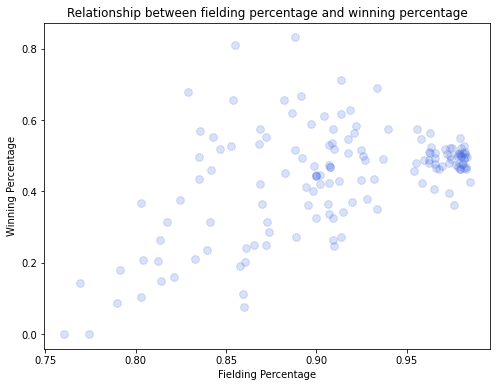

In [0]:
plt.figure(figsize=[8,6])
plt.scatter(winning_percentage_df.fielding_percentage, winning_percentage_df.winning_percentage, 
            alpha=0.2, c='royalblue', s=60)
plt.title('Relationship between fielding percentage and winning percentage')
plt.xlabel('Fielding Percentage')
plt.ylabel('Winning Percentage')
plt.show()


Let's calculate the correlation coefficient.

In [0]:
from scipy import stats
stats.pearsonr(winning_percentage_df['winning_percentage'], winning_percentage_df['fielding_percentage']) #compute the correlation coefficient.

Out[52]: (0.49660816463165897, 1.1846352459803614e-10)

###E.6 - Relationship between Earned-Run Average (Pitching) and Winning Percentage

In this subsection, we will calculate the earning run average for each team, then we will join the DataFrame to the teams table in order to calculate the winning percentage. We will sort the result in ascending order by winning percentage and store the result in a pandas DataFrame named earning_run_average. At the end, we will create a scatter plot to view the relationship between the winning percentage and the earned run average (pitching).

In [0]:
earning_run_average = (
    pitching
    .groupBy('teamID')
    .agg(
        expr('SUM(ERA)  AS n_ERA')
    )
     .join(teams,'teamID','left')
    .groupBy('teamID','ERA')
    .agg(
        expr('SUM(DISTINCT W) AS n_win'),
        expr('SUM(DISTINCT L) AS n_loss')
      )
    .select('*', expr('ROUND (n_win / (n_win + n_loss),3) AS winning_percentage'))
    .sort('winning_percentage').toPandas()
)

earning_run_average.head(10)

Out[53]:

,teamID,ERA,n_win,n_loss,winning_percentage
0,WS4,6.18,0,11,0.000
1,BL4,8.00,0,6,0.000
2,BR2,3.16,2,42,0.045
3,KEO,1.83,1,12,0.077
4,ELI,3.26,2,21,0.087
5,BR1,5.55,3,26,0.103
6,WIL,3.04,2,16,0.111
7,CL4,6.37,20,134,0.130
8,CN1,3.62,9,56,0.138
9,PH3,2.71,2,12,0.143


Let's create a scatter plot to view the relationship between winning percentage and fielding percentage.  
Simply looking at the below scatter plot we can observe that most of the data points are concentrated in the middle of the plot (if we exclude all the outliers), which shows that there is a relationship between the winning percentage and the earning run average.  
The correlation coefficient of -.48 is probably due to the outliers as mentioned earlier. This means that there is week negative correlation between the winning percentage and the earning run average.

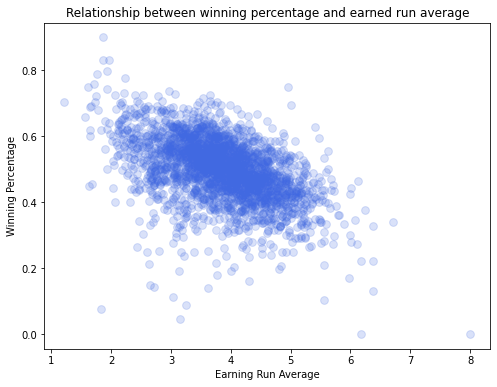

In [0]:
plt.figure(figsize=[8,6])
plt.scatter(earning_run_average.ERA, earning_run_average.winning_percentage, 
            alpha=0.2, c='royalblue', s=60)
plt.title('Relationship between winning percentage and earned run average')
plt.xlabel('Earning Run Average')
plt.ylabel('Winning Percentage')
plt.show()

Let's calculate the correlation coefficient.

In [0]:
from scipy import stats
stats.pearsonr(earning_run_average['winning_percentage'], earning_run_average['ERA']) #compute the correlation coefficient.

Out[55]: (-0.48199189607656123, 1.1027300803781418e-147)

## Section F - Ballparks and Homegames
This section will explore the ballparks and homegames tables.

In order to use the tables of parks and homegames, the column names require changing to match other tables used in this notebook. The updated column names will be used in the later subsections.

In [0]:
parks = parks.toDF('parkID', 'park_name', 'park_alias', 'city', 'state', 'country')
parks.printSchema()
homegames = homegames.toDF('yearID', 'leagueID', 'teamID', 'parkID', 'first_year', 'last_year', 'games', 'openings', 'attendance')
homegames.printSchema()

root
-- parkID: string (nullable = true)
-- park_name: string (nullable = true)
-- park_alias: string (nullable = true)
-- city: string (nullable = true)
-- state: string (nullable = true)
-- country: string (nullable = true)

root
-- yearID: integer (nullable = true)
-- leagueID: string (nullable = true)
-- teamID: string (nullable = true)
-- parkID: string (nullable = true)
-- first_year: string (nullable = true)
-- last_year: string (nullable = true)
-- games: integer (nullable = true)
-- openings: integer (nullable = true)
-- attendance: integer (nullable = true)

###F.1 - Number of Ballpark Names

The following identifies how many home park names each team has played under and shows the first 10 rows of the new table.

In [0]:
num_parks = teams.groupBy('teamID','name').agg(expr('COUNT (DISTINCT park) as parks')).filter(col('parks') >= 3).sort('parks', ascending = True).toPandas()
num_parks.head(10)

Out[57]:

,teamID,name,parks
0,HOU,Houston Astros,3
1,ATL,Atlanta Braves,3
2,CHN,Chicago Colts,3
3,SDN,San Diego Padres,3
4,TRN,Troy Trojans,3
5,KCA,Kansas City Royals,3
6,PH4,Philadelphia Athletics,3
7,MON,Montreal Expos,3
8,MIN,Minnesota Twins,3
9,PHA,Philadelphia Athletics,3


Next, the team that has the most number of home park's name changes is identified and those names are listed in order from the first to the present.

In [0]:
park_names = (teams.filter(col('name') == 'Cincinnati Reds').select('yearID', 'park').sort('yearID').toPandas())
names = park_names['park'].unique()
print(names[:, None])

[['Avenue Grounds']
 ['Bank Street Grounds']
 ['League Park I in Cincinnati']
 ['League Park II in Cincinnati']
 ['Palace of the Fans']
 ['Crosley Field']
 ['Crosley Field/Riverfront Stadium']
 ['Riverfront Stadium']
 ['Cinergy Field']
 ['Great American Ball Park']]

The following will graphically show the number of home park names for each team based on the team having played under at least three different names and that the park is currently open.

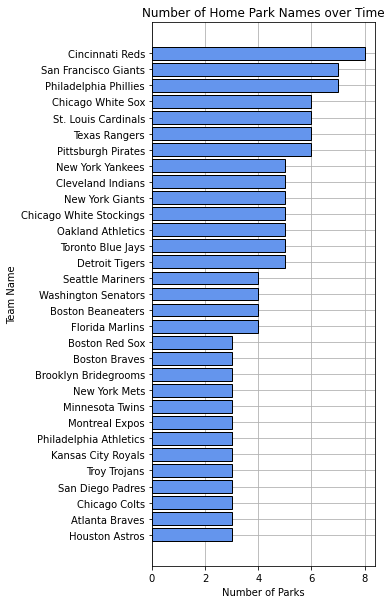

In [0]:
plt.figure(figsize=[4,10])

plt.barh(num_parks.name, num_parks.parks, color='cornflowerblue', edgecolor='k', zorder = 2)
plt.title('Number of Home Park Names over Time')
plt.xlabel('Number of Parks')
plt.ylabel('Team Name')
plt.grid()
plt.show()

###F.2 - Age of Current Parks
In this subsection, we will calculate the age of the parks currently active. This will then be shown graphically in a horizontal bar graph.

In order to determine the age of the current parks, we will use the join, grouping and aggregation operations. We have chosen to filter by parks that had to be in existence for 15 years and is currently active.  
Based on the bar graph, the oldest parks are Fenway Park and Wrigley Field and the newest parks are Citizen Bank Park and PETCO Park.

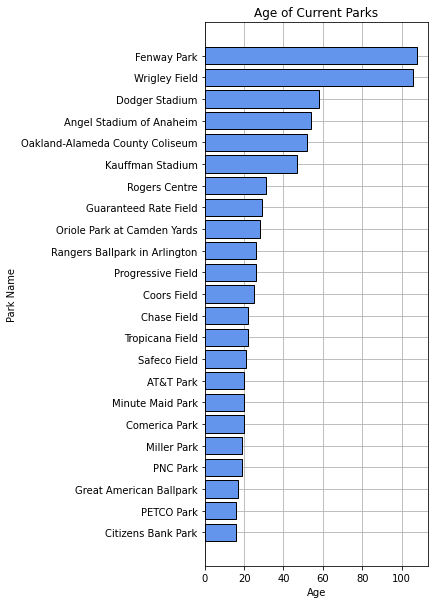

In [0]:
age_of_park = (
    parks
    .join(homegames, 'parkID', 'inner')
    .groupBy('park_name')
    .agg(       
        expr('COUNT(DISTINCT(yearID)) as age'),
        expr('MAX(yearID) as last_year')
    )
    .filter((col('age') >= 15) & (col('last_year') == 2019))
    .sort('age', ascending = True).toPandas()
)

plt.figure(figsize=[4,10])

plt.barh(age_of_park.park_name, age_of_park.age, color='cornflowerblue', edgecolor='k', zorder = 2)
plt.title('Age of Current Parks')
plt.xlabel('Age')
plt.ylabel('Park Name')
plt.grid()
plt.show()

### F.3 - Top Parks by Attendance
The following subsection will create a dataframe by joining the parks and homegames tables to analyze the top parks by attendance.

Let's select the columns 'yearID', 'park_name', 'games', 'attendance', 'teamID', and 'parkID' and show the top 10 parks with the greatest average attendance at homegames.

In [0]:
homegames_by_parks = (
    homegames
    .join(parks, 'parkID', 'left')
    .select('yearID','park_name', 'games','attendance', 'teamID', 'parkID')
    .groupBy('parkID', 'park_name')
  .agg(
      expr('MIN(yearID) AS first_year'),
      expr('MAX(yearID) AS last_year'),
      expr('COUNT(DISTINCT (yearID)) AS seasons'),
      expr('INT(MEAN(games)) AS avg_games'),
      expr('INT(MEAN(attendance)) AS avg_attendance') 
      )
   .sort('avg_attendance', 'park_name', ascending = False)    
  )
homegames_by_parks.toPandas().head(10)

Out[61]:

,parkID,park_name,first_year,last_year,seasons,avg_games,avg_attendance
0,DEN01,Mile High Stadium,1993,1994,2,69,3882333
1,NYC21,Yankee Stadium II,2009,2019,11,81,3414714
2,STL10,Busch Stadium III,2006,2019,14,80,3399881
3,SFO03,AT&T Park,2000,2019,20,77,3052820
4,DEN02,Coors Field,1995,2019,25,80,2880923
5,LOS03,Dodger Stadium,1962,2019,58,79,2856612
6,PHI13,Citizens Bank Park,2004,2019,16,76,2690794
7,ATL02,Turner Field,1997,2016,20,80,2620877
8,BAL12,Oriole Park at Camden Yards,1992,2019,28,79,2577160
9,ATL03,Suntrust Park,2017,2019,3,81,2571984


### F.4 - Homegames per Year
In this subsection, we will create a DataFrame to view the homegames per year and view the trend over time by using a line plot.

Since we had identified in the previous subsection the top 10 parks with the greatest average attendance at homegames, we evaluated how many games were played at home per year. The line plot shows that the number of homegames has increased over the last few decades.

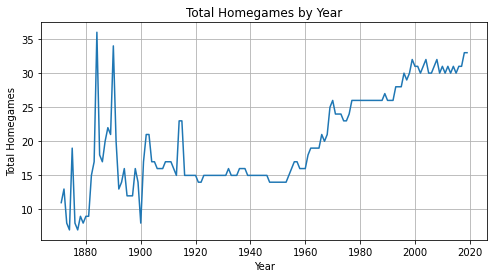

In [0]:
hg_by_Year = (
    homegames
    .groupBy('yearID')
    .agg(
         expr('COUNT(DISTINCT(parkID)) AS total_hg')
            )
    .sort('yearID', ascending = True)
    .toPandas()
)

plt.figure(figsize=[8,4])

plt.plot(hg_by_Year.yearID, hg_by_Year.total_hg)
plt.xlabel('Year')
plt.ylabel('Total Homegames')
plt.title('Total Homegames by Year')
plt.grid()
plt.show()

###F.5 - Fan Attendance Based on Team's Winning and Loss Percentages 
In this subsection, we will evaluate if fan attendance correlates with the Win and Loss Percentages.

In addition to seeing an increase in homegames per year, we wanted to evaluate if there is a correlation between win and loss percentages. First, we evaluate using the teams table to calculate the winning percentage and fan attendance. Display the top 10 winning percentages, teams, and fan attendance. We can confirm that there is a trend of increased fan attendance when a team has a high winning percentage.    
**Note:** Filtered data to remove the year 2020 since there were no fans in parks due to pandemic.

In [0]:
win_perc_attend =( 
    teams
    .select(
        'yearID', 'teamID', 'attendance', 'W','L','G',
        expr('ROUND(W / G,2) AS win_per'),
        expr('ROUND(L / G,2) AS loss_per'),
    )
    .filter(expr('yearID <= 2019')) 
    .select(
        'yearID', 'teamID', 'attendance', 'win_per',
        
    )
    .sort('yearID','win_per', ascending = False).toPandas()
    
)

win_perc_attend.head(10)


Out[63]:

,yearID,teamID,attendance,win_per
0,2019,HOU,2857367.0,0.66
1,2019,LAN,3974309.0,0.65
2,2019,NYA,3304404.0,0.64
3,2019,MIN,2294152.0,0.62
4,2019,ATL,2655100.0,0.60
5,2019,OAK,1662211.0,0.60
6,2019,TBA,1178735.0,0.59
7,2019,CLE,1738642.0,0.57
8,2019,WAS,2259781.0,0.57
9,2019,SLN,3480393.0,0.56


Next, we evaluate using the teams table to calculate the loss percentage and fan attendance. Display the top 10 loss percentages, teams, and fan attendance. We can confirm that there is a trend of decreased fan attendance when a team has a high loss percentage.  
**Note:** Filtered data to remove the year 2020 since there were no fans in parks due to pandemic.

In [0]:

loss_perc_attend =( 
    teams
    .select(
        'yearID', 'teamID', 'attendance', 'W','L','G',
        expr('ROUND(W / G,2) AS win_per'),
        expr('ROUND(L / G,2) AS loss_per'),
    )
    .filter(expr('yearID <= 2019')) # filtered data to remove the year 2020 since there were no fans in stadium
    .select(
        'yearID', 'teamID', 'attendance', 'loss_per'
        
    )
    .sort('yearID','loss_per', ascending = False).toPandas()
    
)

loss_perc_attend.head(10)

Out[64]:

,yearID,teamID,attendance,loss_per
0,2019,DET,1501430.0,0.71
1,2019,BAL,1307807.0,0.67
2,2019,MIA,811302.0,0.65
3,2019,KCA,1479659.0,0.64
4,2019,TOR,1750114.0,0.59
5,2019,SEA,1791863.0,0.58
6,2019,PIT,1491439.0,0.57
7,2019,SDN,2396399.0,0.57
8,2019,COL,2993244.0,0.56
9,2019,LAA,3019012.0,0.56


### F.6 - Attendance based on Awards
The total number of awards from 1998 to the present will be compared with the total homegame attendance in the same time period to discover if the two are related.

The table shown below displays the top ten teams with the most awards won from 1998 to the present.

In [0]:
top_awards = awards.join(appearances, 'playerID', 'inner').filter(awards.yearID >= 1998).groupBy('teamID').agg(expr('COUNT(awardID) as num_awards')).sort('num_awards', ascending = False).toPandas()
top_awards.head(10)

Out[65]:

,teamID,num_awards
0,NYA,2138
1,BOS,1216
2,SEA,1144
3,ATL,1090
4,TEX,1005
5,SLN,984
6,LAN,948
7,SFN,930
8,DET,802
9,PHI,782


The table displayed below shows the ten teams with the highest total homegame attendance from 1998 to the present.

In [0]:
hg_attendance = homegames.filter(col('yearID') >= 1998).groupBy('teamID').agg(expr('SUM(attendance) as total_attendance')).sort('total_attendance', ascending = False).toPandas()
hg_attendance.head(10)

Out[66]:

,teamID,total_attendance
0,NYA,77907999
1,LAN,77099563
2,SLN,72988729
3,SFN,68070927
4,CHN,65704266
5,BOS,62571787
6,COL,60821128
7,NYN,58977493
8,ATL,56698483
9,PHI,56440144


The table below is a display of the two previous tables combined.

In [0]:
full = pd.merge(top_awards, hg_attendance, on = ['teamID'])
full.head(10)

Out[67]:

,teamID,num_awards,total_attendance
0,NYA,2138,77907999
1,BOS,1216,62571787
2,SEA,1144,54595896
3,ATL,1090,56698483
4,TEX,1005,56422687
5,SLN,984,72988729
6,LAN,948,77099563
7,SFN,930,68070927
8,DET,802,51148471
9,PHI,782,56440144


The next visual display is a line and bar chart graph comparing the total number of awards to the total homegame attendance. While the New York Yankees have both the highest number of awards and the highest homegame attendance, the rest of the graph does not lead to a conclusion that the two are directly related.

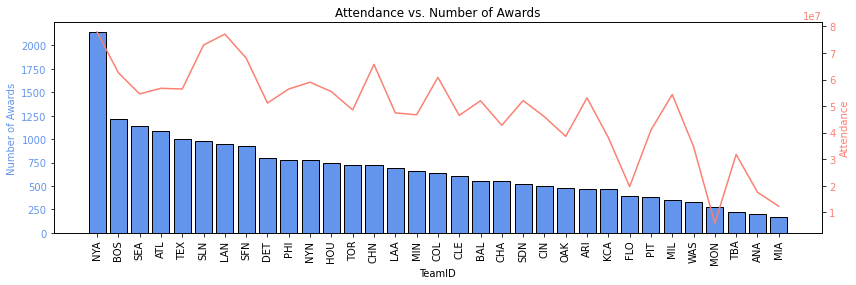

In [0]:
fig, ax1 = plt.subplots(figsize=(12, 4))


color = 'cornflowerblue'
ax1.set_xlabel('TeamID')
ax1.set_ylabel('Number of Awards', color= color)
ax1.bar(full.teamID, full.num_awards, color=color, edgecolor = 'k')
ax1.tick_params(axis = 'x', rotation = 90)
ax1.tick_params(axis='y', labelcolor=color)
 
ax2 = ax1.twinx()

color = 'salmon'
ax2.set_ylabel('Attendance', color=color)
ax2.plot(full.teamID, full.total_attendance, color=color)
ax2.tick_params(axis = 'x', rotation = 90)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()
plt.title('Attendance vs. Number of Awards')
plt.show() 